In [10]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from cotracker.utils.visualizer import Visualizer, read_video_from_path

from cotracker.predictor import CoTrackerPredictor

In [ ]:
model = CoTrackerPredictor(
    checkpoint=os.path.join(
        './checkpoints/cotracker_stride_4_wind_8.pth'
    )
).cuda()

In [11]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width="640" height="480" autoplay loop controls><source src="{video_url}"></video>""")

In [3]:
import torch
import SimpleITK as sitk
import numpy as np

def load_cine_mr_data(folder_path):
    # 读取所有.DCM文件
    file_names = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.IMA')]
    file_names.sort()  # 确保文件是按顺序排列的

    # 读取图像并存入列表
    images = [sitk.ReadImage(f) for f in file_names]

    # 确保所有图像具有相同的尺寸
    size = images[0].GetSize()
    if not all(image.GetSize() == size for image in images):
        raise RuntimeError("Not all images have the same size")

    # 将SimpleITK图像转换为numpy数组
    arrays = [sitk.GetArrayFromImage(image) for image in images]

    # 扩展通道维度（从1到3）
    arrays = [np.stack([arr]*3, axis=-1) for arr in arrays]

    # 将列表转换为numpy数组
    data = np.stack(arrays, axis=0)
    # 将numpy.uint16类型转换为numpy.float32类型
    data = data.astype(np.float32)

    # standardize data to RGB range
    data /= data.max()
    data *= 255.0

    # 转换为Torch Tensor并调整尺寸为[b, t, c, h, w]
    tensor = torch.from_numpy(data).float()
    tensor = tensor.permute(1, 0, 4, 2, 3)

    return tensor

# 使用示例
root = '/nfs/asmfsfs03/cptMRgPT/data/anonymized'
rpath = 'data_re4DMRI/REP4DMRI_V20_REMR20/__20230224_105335_990000/4DMRI_SHORT_CORONAL_4_5SLICETHICKNESS_0004'
folder_path = os.path.join(root, rpath)

video = load_cine_mr_data(folder_path).cuda()
print(video.shape)  # 打印tensor的形状以确认

torch.Size([1, 768, 3, 384, 300])


In [4]:
import torch
import torch.nn.functional as F
from skimage import morphology
import numpy as np
import SimpleITK as sitk

def load_cine_mr_data(folder_path):
    # 读取所有.DCM文件
    file_names = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.IMA')]
    file_names.sort()  # 确保文件是按顺序排列的

    # 读取图像并存入列表
    images = [sitk.ReadImage(f) for f in file_names]
    
    # 确保所有图像具有相同的尺寸
    size = images[0].GetSize()
    if not all(image.GetSize() == size for image in images):
        raise RuntimeError("Not all images have the same size")

    # 将SimpleITK图像转换为numpy数组
    arrays = [sitk.GetArrayFromImage(image) for image in images]

    # 扩展通道维度（从1到3）
    arrays = [np.stack([arr]*3, axis=-1) for arr in arrays]

    # 将列表转换为numpy数组
    data = np.stack(arrays, axis=0)
    # 将numpy.uint16类型转换为numpy.float32类型
    data = data.astype(np.float32)

    # standardize data to RGB range
    data = (data - data.min()) / (data.max() - data.min()) * 255
    
    # 转换为Torch Tensor并调整尺寸为[b, t, c, h, w]
    tensor = torch.from_numpy(data).float()
    tensor = tensor.permute(1, 0, 4, 2, 3)
    
    # generate mask from the first frame
    mask = tensor[0,0] > 0.5
    # Convert mask to a numpy array
    mask_np = mask.numpy()
    # Create a 3D circular structuring element with a specified radius
    radius = 3
    selem = morphology.ball(radius)

    mask_eroded = morphology.binary_erosion(mask_np, selem)

    # Connected component labeling
    labeled_mask, num_features = morphology.label(mask_eroded, connectivity=2, return_num=True)

    # Find the largest connected component (assuming it's the object of interest)
    largest_component = labeled_mask == np.argmax(np.bincount(labeled_mask.flat)[1:]) + 1

    # Fill all the holes in the mask to ensure it's a single connected component
    cleaned_mask_np = morphology.remove_small_holes(largest_component, area_threshold=1000)
    cleaned_mask_np = morphology.convex_hull_image(cleaned_mask_np)
    # Convert the cleaned mask back to a torch tensor
    cleaned_mask = torch.from_numpy(cleaned_mask_np).float()
        
    return tensor, cleaned_mask

# 使用示例
root = '/nfs/asmfsfs03/cptMRgPT/data/anonymized'
rpath = 'data_re4DMRI/REP4DMRI_V18_REMR18/__20230217_143035_870000/4DMRI_SHORT_CORONAL_4_5SLICETHICKNESS_0004/'
folder_path = os.path.join(root, rpath)
video, mask = load_cine_mr_data(folder_path)
print(video.shape)  # 打印tensor的形状以确认

torch.Size([1, 768, 3, 384, 300])


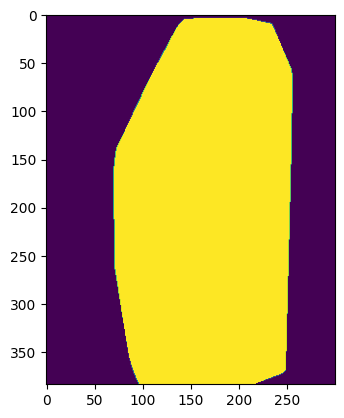

In [5]:
# visualize the mask
import matplotlib.pyplot as plt
plt.imshow(mask[0].cpu().numpy())

In [6]:
video = video.cuda()
mask = mask.cuda()

In [7]:
pred_tracks, pred_visibility = model(video, grid_size=30, segm_mask=mask[None])

In [9]:
vis = Visualizer(save_dir=rpath, pad_value=10, linewidth=0)
vis.visualize(video=video, tracks=pred_tracks, visibility=pred_visibility, filename='vertmri_40')

Video saved to data_re4DMRI/REP4DMRI_V18_REMR18/__20230217_143035_870000/4DMRI_SHORT_CORONAL_4_5SLICETHICKNESS_0004/vertmri_40_pred_track.mp4


tensor([[[[[255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           ...,
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255]],

          [[255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           ...,
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255]],

          [[255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           ...,
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255]]],


         [[[255, 255, 255,  ..., 255, 255, 255],
           [2

In [10]:
show_video(os.path.join(rpath,"vertmri_40_pred_track.mp4"))

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def select_points_interactive(video, num_points=4):
    """
    Displays the first frame of the video and allows interactive selection of points.

    Parameters:
    - video: The video tensor in the format [b, t, c, h, w].
    - num_points: Number of points to select.

    Returns:
    - A list of selected points (x, y).
    """
    # Extract the first frame from the video tensor
    # Assuming video shape is [b, t, c, h, w] and taking the first frame of the first batch
    first_frame = video[0, 0].cpu().numpy()  # Convert to numpy array
    first_frame = np.transpose(first_frame, (1, 2, 0))  # Change to HWC format for plotting
    first_frame = first_frame.astype(np.uint8)  # Ensure it's in the correct data type for displaying
    
    points = []  # To hold selected points
    fig, ax = plt.subplots()
    ax.imshow(first_frame)

    def onclick(event):
        if event.xdata is not None and event.ydata is not None and len(points) < num_points:
            points.append(0, (int(event.xdata), int(event.ydata)))
            ax.plot(event.xdata, event.ydata, 'ro')
            fig.canvas.draw()

    def onkey(event):
        if event.key == 'z' and points:
            points.pop()
            ax.clear()
            ax.imshow(first_frame)
            for point in points:
                ax.plot(point[0], point[1], 'ro')
            fig.canvas.draw()

    fig.canvas.mpl_connect('button_press_event', onclick)
    fig.canvas.mpl_connect('key_press_event', onkey)
    plt.show()
    
    points = torch.tensor(points, dtype=torch.float32)
    return points

# Assuming 'video' is your loaded video tensor and already on the correct device
# Example usage:
num_points = 4  # Specify how many points you want to select
selected_points = select_points_interactive(video, num_points=num_points)
print("Selected points:", selected_points)

<IPython.core.display.Javascript object>

Selected points: []


In [4]:
queries = torch.tensor([
    [0., 20., 40.],  # point tracked from the first frame
    [0., 40., 90.], # frame number 10
    [0., 60., 120.], # ...
    [0., 70., 160.]
])
if torch.cuda.is_available():
    queries = queries.cuda()

In [5]:
import matplotlib.pyplot as plt
# Create a list of frame numbers corresponding to each point
frame_numbers = queries[:,0].int().tolist()

fig, axs = plt.subplots(2, 2)
axs = axs.flatten()

for i, (query, frame_number) in enumerate(zip(queries, frame_numbers)):
    ax = axs[i]
    ax.plot(query[1].item(), query[2].item(), 'ro') 
    
    ax.set_title("Frame {}".format(frame_number))
    ax.set_xlim(0, video.shape[4])
    ax.set_ylim(0, video.shape[3])
    ax.invert_yaxis()
    
plt.tight_layout()
plt.show()

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [13]:
pred_tracks, pred_visibility = model(video, queries=queries[None])

In [14]:
vis = Visualizer(
    save_dir='./videos',
    linewidth=1,
    mode='cool'
)
vis.visualize(
    video=video,
    tracks=pred_tracks,
    visibility=pred_visibility,
    filename='vertmr_queries');

Video saved to ./videos/vertmr_queries_pred_track.mp4


In [15]:
show_video("./videos/vertmr_queries_pred_track.mp4")

In [ ]:
import os
import torch
import torch.nn.functional as F
from skimage import morphology
import numpy as np
import SimpleITK as sitk

def load_cine_mr_data(folder_path):
    # 读取所有.DCM文件
    file_names = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.IMA')]
    file_names.sort()  # 确保文件是按顺序排列的

    # 读取图像并存入列表
    images = [sitk.ReadImage(f) for f in file_names]
    
    # 确保所有图像具有相同的尺寸
    size = images[0].GetSize()
    if not all(image.GetSize() == size for image in images):
        raise RuntimeError("Not all images have the same size")

    # 将SimpleITK图像转换为numpy数组
    arrays = [sitk.GetArrayFromImage(image) for image in images]

    # 扩展通道维度（从1到3）
    arrays = [np.stack([arr]*3, axis=-1) for arr in arrays]

    # 将列表转换为numpy数组
    data = np.stack(arrays, axis=0)
    # 将numpy.uint16类型转换为numpy.float32类型
    data = data.astype(np.float32)
    print(data.shape)

    # standardize data to RGB range
    data = (data - data.min()) / (data.max() - data.min()) * 255
    
    # 转换为Torch Tensor并调整尺寸为[b, t, c, h, w]
    tensor = torch.from_numpy(data).float()
    tensor = tensor.permute(1, 0, 4, 2, 3)
    
    # generate mask from the first frame
    mask = tensor[0,0] > 0.5
    # Convert mask to a numpy array
    mask_np = mask.numpy()
    # Create a 3D circular structuring element with a specified radius
    radius = 3
    selem = morphology.ball(radius)

    mask_eroded = morphology.binary_erosion(mask_np, selem)

    # Connected component labeling
    labeled_mask, num_features = morphology.label(mask_eroded, connectivity=2, return_num=True)

    # Find the largest connected component (assuming it's the object of interest)
    largest_component = labeled_mask == np.argmax(np.bincount(labeled_mask.flat)[1:]) + 1

    # Convert the cleaned mask back to a torch tensor
    cleaned_mask = torch.from_numpy(largest_component).float()
        
    return tensor, cleaned_mask

# 使用示例
folder_path = '/nfs/asmfsfs03/cptMRgPT/data/anonymized/data_re4DMRI/REP4DMRI_V20_REMR20/__20230224_105335_990000/4DMRI_SHORT_CORONAL_4_5SLICETHICKNESS_0004/'  # 替换为你的文件夹路径
video, mask = load_cine_mr_data(folder_path)
print(video.shape)  # 打印tensor的形状以确认


In [ ]:
# visualize the mask
import matplotlib.pyplot as plt
plt.imshow(mask[0].cpu().numpy())

In [ ]:
video = video.cuda()
mask = mask.cuda()

In [ ]:
pred_tracks, pred_visibility = model(video, grid_size=30, segm_mask=mask[None])
vis = Visualizer(
    save_dir='./videos',
    pad_value=10,
    linewidth=1,
)
vis.visualize(
    video=video,
    tracks=pred_tracks,
    visibility=pred_visibility,
    filename='segm_grid_mr')

In [18]:
show_video("./results/data_verticalMR/Torso_lowMR/VMRI04/D1_upright/7_HASTE_dyn_sag_single/20240226-105659_pred_track.mp4")

In [14]:
import numpy as np
track = np.load('results/data_verticalMR/Torso_lowMR/VMRI07/D1_upright/4_HASTE_dyn_sag_single/20240226-104554_pred_tracks.npy')

In [15]:
track

array([[[[ 38.      ,  74.      ],
         [ 48.      ,  79.      ],
         [ 59.      ,  89.      ],
         [ 65.      ,  98.      ]],

        [[ 37.374653,  77.90015 ],
         [ 47.014046,  84.71705 ],
         [ 57.54397 ,  96.473564],
         [ 63.354702, 106.47915 ]],

        [[ 37.607697,  79.62873 ],
         [ 47.29365 ,  86.01844 ],
         [ 57.979908,  97.05017 ],
         [ 63.881786, 106.47166 ]],

        ...,

        [[ 39.401558,  82.61875 ],
         [ 50.877655,  89.24182 ],
         [ 60.735317, 100.94604 ],
         [ 65.72961 , 108.16429 ]],

        [[ 39.749016,  81.180885],
         [ 51.163525,  87.42961 ],
         [ 60.859234,  98.69382 ],
         [ 65.832466, 105.89207 ]],

        [[ 39.570507,  80.90626 ],
         [ 51.00461 ,  87.560074],
         [ 60.76622 ,  99.618034],
         [ 65.73802 , 107.16028 ]]]], dtype=float32)